In [2]:
from astroquery.gaia import Gaia
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:

query = """
SELECT TOP 10000000 ra, dec, parallax, pmra, pmdec, phot_g_mean_mag,
bp_rp, phot_g_mean_mag+5*log10(parallax)-10 as mg, radius_val
FROM gaiadr3.gaia_source
WHERE parallax > 1.
"""

job = Gaia.launch_job(query)
results = job.get_results()
print(len(results))


786433


In [4]:

gdata = results.to_pandas()
print(gdata)

                ra        dec  parallax       pmra     pmdec  phot_g_mean_mag  \
0       274.416636 -21.319055  1.896151  -6.537800 -0.204295        20.330873   
1       302.615485 -18.896738  1.198711  -3.200111 -9.267362        18.484478   
2       302.618756 -18.890770  1.476347 -13.415397 -6.902121        16.785004   
3       302.594492 -18.902811  1.220471  -4.959003 -5.577459        20.054167   
4       273.113457 -21.909938  2.075234  -2.212278  1.363261        19.523180   
...            ...        ...       ...        ...       ...              ...   
786428  298.683330  29.154877  1.417000  -1.641154 -3.317582        19.863302   
786429  298.367184  28.518767  1.093617  -2.565608 -2.005326        20.516615   
786430  298.362246  28.513783  1.245006  -3.605714 -4.145670        20.603922   
786431  298.372731  28.509429  1.077651  10.002924 -1.183019        19.000059   
786432  298.566938  28.212797  1.368022  -0.949964 -2.096267        15.451203   

           bp_rp         mg

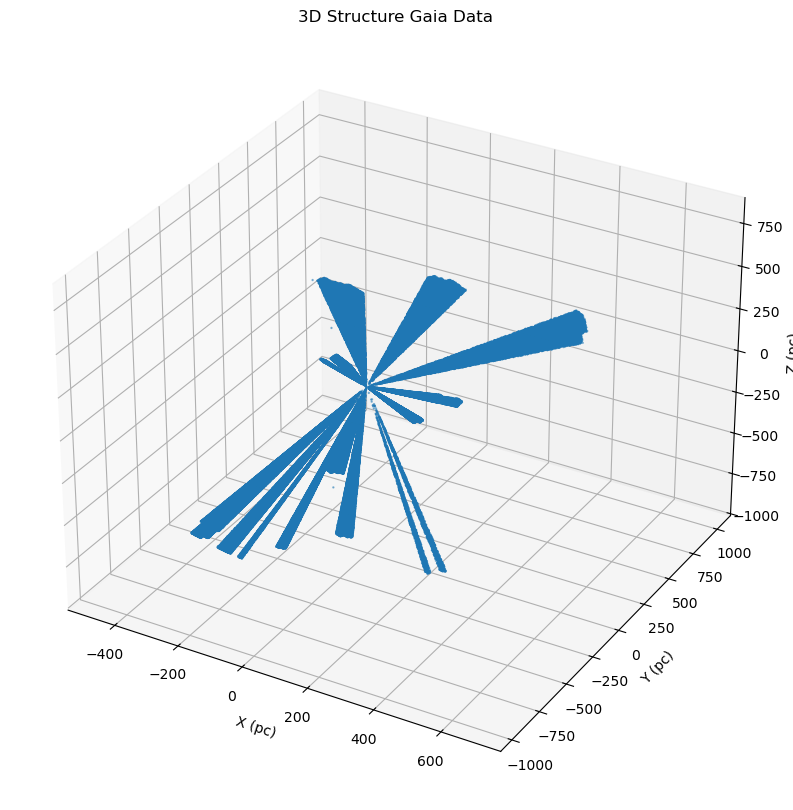

In [6]:


# Sample RA, Dec, and parallax arrays (replace with Gaia data)
ra = np.array(gdata['ra'])
dec = np.array(gdata['dec'])
parallax = np.array(gdata['parallax'])
bp_rp = np.array(gdata['bp_rp'])
mg = np.array(gdata['mg'])

# Convert parallax to distance (parsecs)
distance = 1000 / parallax

# Convert to Cartesian coordinates
x = distance * np.cos(np.radians(ra)) * np.cos(np.radians(dec))
y = distance * np.sin(np.radians(ra)) * np.cos(np.radians(dec))
z = distance * np.sin(np.radians(dec))

# Plot in 3D
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=0.5, alpha=0.5) 

ax.set_xlabel("X (pc)")
ax.set_ylabel("Y (pc)")
ax.set_zlabel("Z (pc)")
plt.title("3D Structure Gaia Data")
plt.show()


[11.72023808  8.87805048  7.63094609 ... 11.07977882  9.16244944
  6.13166885]
Magnitude if G filter data in array mg, with length  700327
Mag in G_BP filter - Mag in G_RP filter in array bp_rp, with length  700327


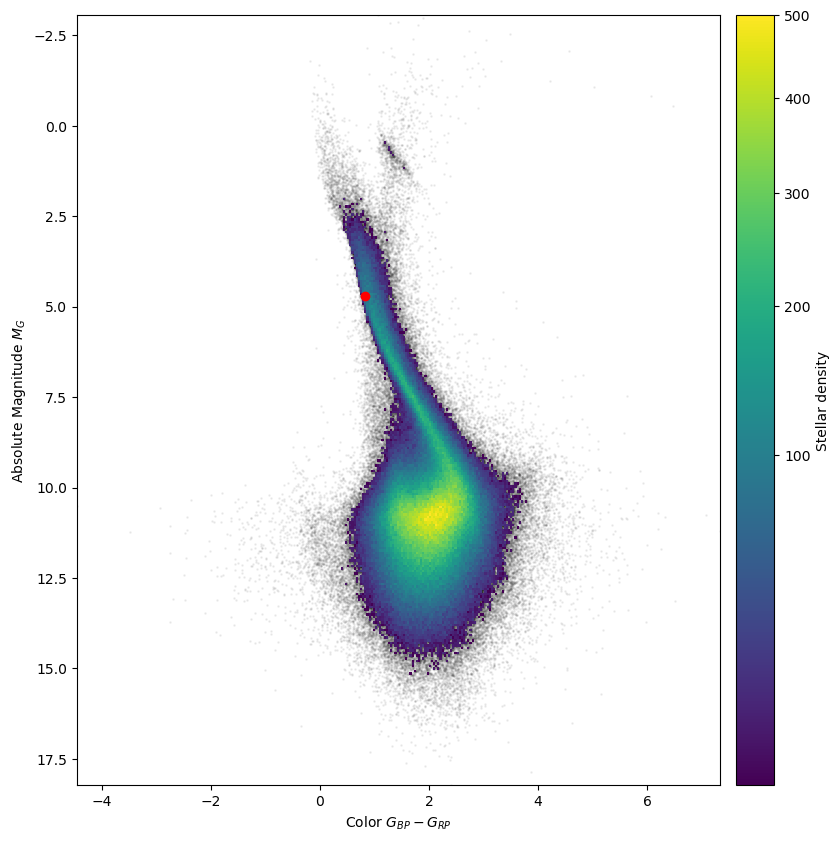

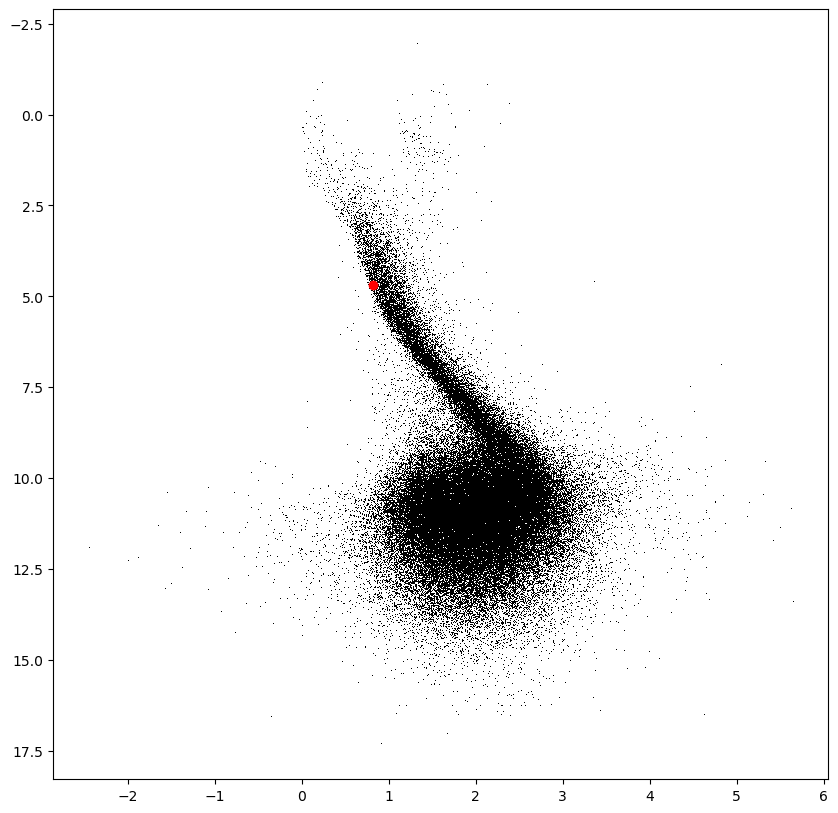

In [7]:

# plot the H-R diagram for 1 M stars within 200 pc from the Sun
from matplotlib import colors
bp_rp = np.array(gdata['bp_rp'])
mg = np.array(gdata['mg'])

# Remove NaN values
mask = ~np.isnan(bp_rp) & ~np.isnan(mg)
bp_rp = bp_rp[mask]
mg = mg[mask]

print(mg)
# Subsample the data with n_rand point:


print('Magnitude if G filter data in array mg, with length ',mg.size)
print('Mag in G_BP filter - Mag in G_RP filter in array bp_rp, with length ',bp_rp.size)


fig, ax = plt.subplots(figsize=(10, 10))
## only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(bp_rp[:-1], mg[:-1], bins=300, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)

# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(bp_rp, mg, alpha=0.05, s=1, color='k', zorder=0)
ax.invert_yaxis()
cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel('Color '+r'$G_{BP} - G_{RP}$')
ax.set_ylabel('Absolute Magnitude '+r'$M_G$')
cb.set_label(r'Stellar density')
plt.plot([0.82],[4.7],'ro')   # Plot the approximate location of the Sun
plt.show()


# Subsample the data with n_rand point:
n_rand = 100000
index = np.arange(mg.size)
index_s = np.random.choice(index,n_rand)
xs = bp_rp[index_s]
ys = mg[index_s]

# Make a plot of all the subsampled point:

fig, ax = plt.subplots(figsize=(10, 10))
plt.plot(xs,ys,'k,')
plt.plot([0.82],[4.7],'ro')   # Plot the approximate location of the Sun
ax.invert_yaxis()
plt.show()


469432143583645.0 578860031644348.5 383381682023232.94


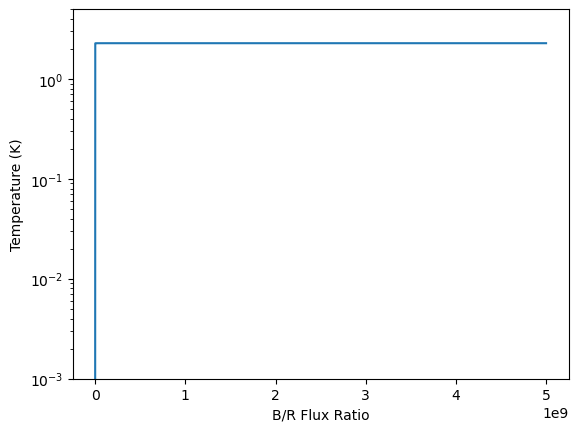

NameError: name 'F_B_over_F_R' is not defined

In [9]:
# First, set up a bunc hof constants:

lambda_G = 639.07
ZAB_G = 25.8010
ZV_G = 25.6878

lambda_B = 518.26
ZAB_B = 25.3540
ZV_B = 25.3385

lambda_R = 782.51
ZAB_R = 25.1040
ZV_R = 24.7479

# Set up some constants

k = 1.3807e-16  # cm2 g s-2 K-1   Boltzmann's constant
h = 6.6261e-27  # cm2 g s-1       Plank's constant
cl = 3.e10      # cm/s   Speed of light
sigma = 5.67e-5  # Steffan-Boltzmann constant cgs

# Find the central frequency for each band:

nu_G = cl/(lambda_G*1.e-7)
nu_B = cl/(lambda_B*1.e-7)
nu_R = cl/(lambda_R*1.e-7)

print(nu_G, nu_B, nu_R)


# Create an array of temperatures

T_max = 5.e9
T_min = 1000
T_arr = np.logspace(np.log10(T_min),np.log10(T_max),10000)


# Find the emissivity in eahc band, as a function of temperature:

I_nu_G = 2*h/cl**2 * nu_G**3 / (np.exp(h*nu_G/(k*T_arr))-1)
I_nu_B = 2*h/cl**2 * nu_B**3 / (np.exp(h*nu_B/(k*T_arr))-1)
I_nu_R = 2*h/cl**2 * nu_R**3 / (np.exp(h*nu_R/(k*T_arr))-1)


# Plot B/R flux ratio as a function of temperature

plt.plot(T_arr,I_nu_B/I_nu_R)
plt.yscale('log')
plt.ylim(1.e-3,5.)
plt.xlabel('B/R Flux Ratio')
plt.ylabel('Temperature (K)')
plt.show()



# Interpolate to find the temperature for each B/R flux ratio observation:

T = np.interp(F_B_over_F_R,I_nu_B/I_nu_R,T_arr)
